https://quickdraw.withgoogle.com/data/octopus

In [1]:
import numpy as np
import pandas as pd
import h5py

import keras
from keras.models import Model, Sequential
from keras.layers import Input, Activation, Conv2D, AveragePooling2D, Reshape, Dense, BatchNormalization, Dropout, Flatten, UpSampling2D, Conv2DTranspose
from keras.optimizers import RMSprop
from keras.initializers import TruncatedNormal
from keras import backend as K


from matplotlib import pyplot as plt
%matplotlib inline

#from pushbullet import Pushbullet

Using TensorFlow backend.
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
data = np.load('../../quickdraw_data/apple.npy')
data = data/255
data = np.reshape(data,(data.shape[0],28,28,1))
img_w,img_h = data.shape[1:3]
data.shape

(144722, 28, 28, 1)

3420


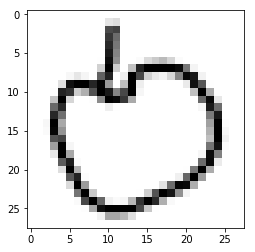

In [3]:
n = np.random.randint(data.shape[0])
print(n)
sample_image = data[n]
plt.imshow(sample_image[:,:,0], cmap='Greys')

In [4]:
def discriminator_builder(depth=64,p=0.4):
    
    # Define inputs
    inputs = Input((img_w,img_h,1))
    
    # Convolutional layers
    conv1 = Conv2D(depth*1, 5, strides=2, padding='same', activation='relu')(inputs)
    conv1 = Dropout(p)(conv1)
    
    conv2 = Conv2D(depth*2, 5, strides=2, padding='same', activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)
    
    conv3 = Conv2D(depth*4, 5, strides=2, padding='same', activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)
    
    conv4 = Conv2D(depth*8, 5, strides=1, padding='same', activation='relu')(conv3)
    conv4 = Flatten()(Dropout(p)(conv4))
    
    output = Dense(1, activation='sigmoid')(conv4)
    
    model = Model(inputs=inputs, outputs=output)
    
    return model

discriminator = discriminator_builder()

discriminator.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.0008, clipvalue=1.0, decay=6e-8), metrics=['accuracy'])

In [5]:
def generator_builder(z_dim=100,depth=64,p=0.4):
    
    # Define inputs
    inputs = Input((z_dim,))
    
    # First dense layer
    dense1 = Dense(7*7*64)(inputs)
    dense1 = BatchNormalization(axis=-1,momentum=0.9)(dense1)
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((7,7,64))(dense1)
    dense1 = Dropout(p)(dense1)
    
    # Convolutional layers
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(depth/2), kernel_size=5, padding='same', activation=None,)(conv1)
    conv1 = BatchNormalization(axis=-1,momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)
    
    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(depth/4), kernel_size=5, padding='same', activation=None,)(conv2)
    conv2 = BatchNormalization(axis=-1,momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)
    
    #conv3 = UpSampling2D()(conv2)
    conv3 = Conv2DTranspose(int(depth/8), kernel_size=5, padding='same', activation=None,)(conv2)
    conv3 = BatchNormalization(axis=-1,momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)

    # Define output layers
    output = Conv2D(1, kernel_size=5, padding='same', activation='sigmoid')(conv3)

    # Model definition    
    model = Model(inputs=inputs, outputs=output)
    
    return model

generator = generator_builder()

In [6]:
def adversarial_builder(z_dim=100):
    
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.0004, clipvalue=1.0, decay=3e-8), metrics=['accuracy'])
    return model

AM = adversarial_builder()

In [7]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch #500
499: [D loss: 7.972398, acc: 0.500869]  [A loss: 0.032301, acc: 1.000000]


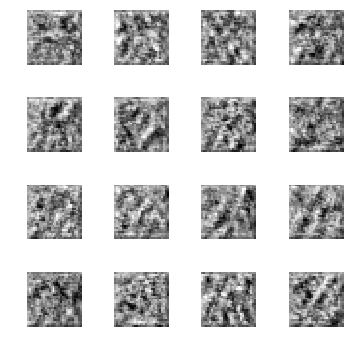

FileNotFoundError: [Errno 2] No such file or directory: './images/run2_500.png'

In [8]:
def train(epochs=2000,batch=128):
    d_loss = []
    a_loss = []
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    for i in range(epochs):
        real_imgs = np.reshape(data[np.random.choice(data.shape[0],batch,replace=False)],(batch,28,28,1))
        fake_imgs = generator.predict(np.random.uniform(-1.0, 1.0, size=[batch, 100]))
        x = np.concatenate((real_imgs,fake_imgs))
        y = np.ones([2*batch,1])
        y[batch:,:] = 0
        make_trainable(discriminator, True)
        d_loss.append(discriminator.train_on_batch(x,y))
        running_d_loss += d_loss[-1][0]
        running_d_acc += d_loss[-1][1]
        make_trainable(discriminator, False)
        
        noise = np.random.uniform(-1.0, 1.0, size=[batch, 100])
        y = np.ones([batch,1])
        a_loss.append(AM.train_on_batch(noise,y))
        running_a_loss += a_loss[-1][0]
        running_a_acc += a_loss[-1][1]
        
        if (i+1)%500 == 0:
            print('Epoch #{}'.format(i+1))
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)
            noise = np.random.uniform(-1.0, 1.0, size=[16, 100])
            gen_imgs = generator.predict(noise)
            plt.figure(figsize=(5,5))
            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], cmap='gray')
                plt.axis('off')
            plt.tight_layout()
            plt.show()
            plt.savefig('./images/run2_{}.png'.format(i+1))
    return a_loss, d_loss
        
a_loss, d_loss = train(epochs=5000)

In [ ]:
ax = pd.DataFrame(
    {
        'Generative Loss': [loss[0] for loss in a_loss],
        'Discriminative Loss': [loss[0] for loss in d_loss],
    }
).plot(title='Training loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

In [ ]:
ax = pd.DataFrame(
    {
        'Generative Loss': [loss[1] for loss in a_loss],
        'Discriminative Loss': [loss[1] for loss in d_loss],
    }
).plot(title='Training Accuracy')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")